In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm ##For estimating the linear models
from statsmodels.graphics import tsaplots ## For making plots of the auto-correlation function
from statsmodels.tsa.ar_model import AutoReg ##For estimating AR models
from statsmodels.graphics.tsaplots import plot_pacf ## For making plots of the partial auto-correlation function
from statsmodels.tsa.stattools import acf ## For performing the Box-Pierce test
from scipy import stats ## For finding the quantiles of the chi-square distribution
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.arima.model import ARIMA

path = r"C:\Users\gbour\Downloads"
data = pd.read_excel(path + r"\BKAM Inflation et inflation sous jacente_.xlsx")

data.head()

,Mois,Inflation,Inflation sous-jacente
0,2020-01-01,1.4,0.5
1,2020-02-01,1.2,0.7
2,2020-03-01,1.6,0.8
3,2020-04-01,0.9,0.9
4,2020-05-01,-0.2,0.8


In [12]:
data.tail()

,Mois,Inflation,Inflation sous-jacente,Delta Inflation
46,2023-11-02,3.6,3.3,-0.7
47,2023-12-04,3.4,2.8,-0.2
48,2024-01-05,2.3,2.5,-1.1
49,2024-02-06,0.3,1.9,-2.0
50,2024-03-09,0.9,2.1,0.6


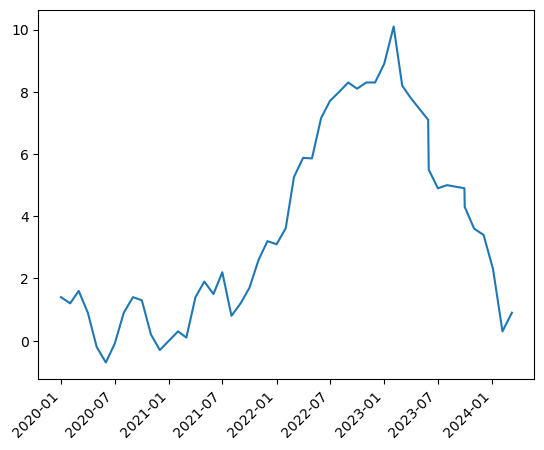

In [35]:
plt.plot(data['Mois'], data['Inflation'])

labels = plt.gca().get_xticklabels()
plt.xticks(rotation=45, ha='right')

plt.show()

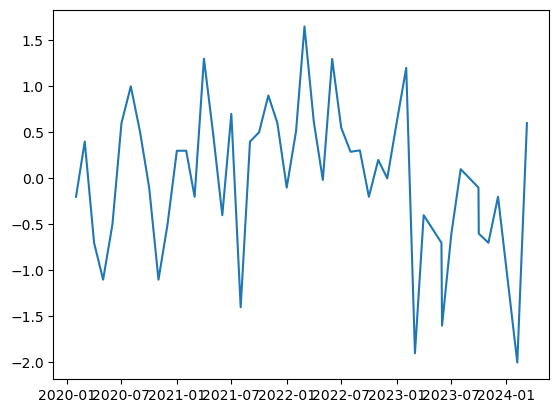

In [3]:
data['Delta Inflation'] = data['Inflation'].diff() ## Compute the series in first difference.
plt.plot(data['Mois'],data['Delta Inflation'])
plt.show()

In [4]:
# Now the series seems stationary and we can start working on it.

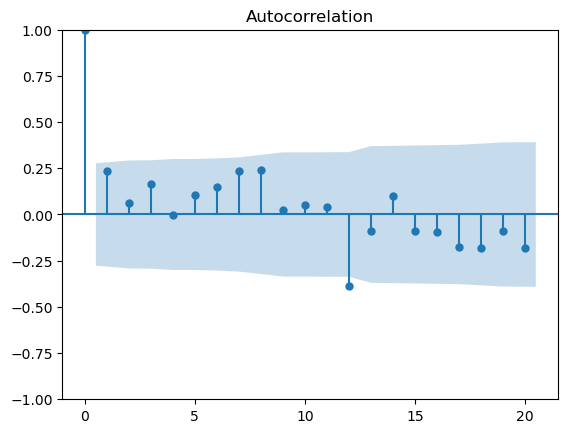

In [5]:
fig = tsaplots.plot_acf(data['Delta Inflation'].iloc[1:], lags=20)
plt.show()

In [14]:
# On this autocorrelogram, we can see that lag 12 is significant, 
# which is logical since inlfation rates are computed on the coresponding month of the previous year.

In [7]:
df_M1 = pd.DataFrame()
df_M1['Mois'] = data['Mois'].iloc[1:].reset_index(drop=True) ### For creating the quarterly dummy
df_M1['Delta Inflation'] = data['Delta Inflation'].iloc[1:].reset_index(drop=True) ### The dependent variable

df_M1.head()

,Mois,Delta Inflation
0,2020-02-01,-0.2
1,2020-03-01,0.4
2,2020-04-01,-0.7
3,2020-05-01,-1.1
4,2020-06-01,-0.5


In [13]:
y = df_M1['Delta Inflation'].to_numpy().copy()

AR = AutoReg(y, lags=[12]).fit()
AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:             Restr. AutoReg(12)   Log Likelihood                 -41.304
Method:               Conditional MLE   S.D. of innovations              0.717
Date:                Mon, 29 Apr 2024   AIC                             88.608
Time:                        12:42:22   BIC                             93.521
Sample:                            12   HQIC                            90.356
                                   50                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1314      0.120      1.098      0.272      -0.103       0.366
y.L12         -0.6020      0.155     -3.880      0.000      -0.906      -0.298
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0077           -0.2700j            1.0432           -0.4583
AR.2            -1.0077           +0.2700j            1.0432            0.4583
AR.3            -0.7377           -0.7377j            1.0432           -0.3750
AR.4            -0.7377           +0.7377j            1.0432            0.3750
AR.5            -0.2700           -1.0077j            1.0432           -0.2917
AR.6            -0.2700           +1.0077j            1.0432            0.2917
AR.7             0.2700           -1.0077j            1.0432           -0.2083
AR.8             0.2700           +1.0077j            1.0432            0.2083
AR.9             0.7377           -0.7377j            1.0432           -0.1250
AR.10            0.7377           +0.7377j            1.0432            0.1250
AR.11            1.0077           -0.2700j            1.0432           -0.0417
AR.12            1.0077           +0.2700j            1.0432            0.0417
------------------------------------------------------------------------------
"""

In [37]:
# Here we can see that both lag 12 is statistically significant (at a 95% percent level).

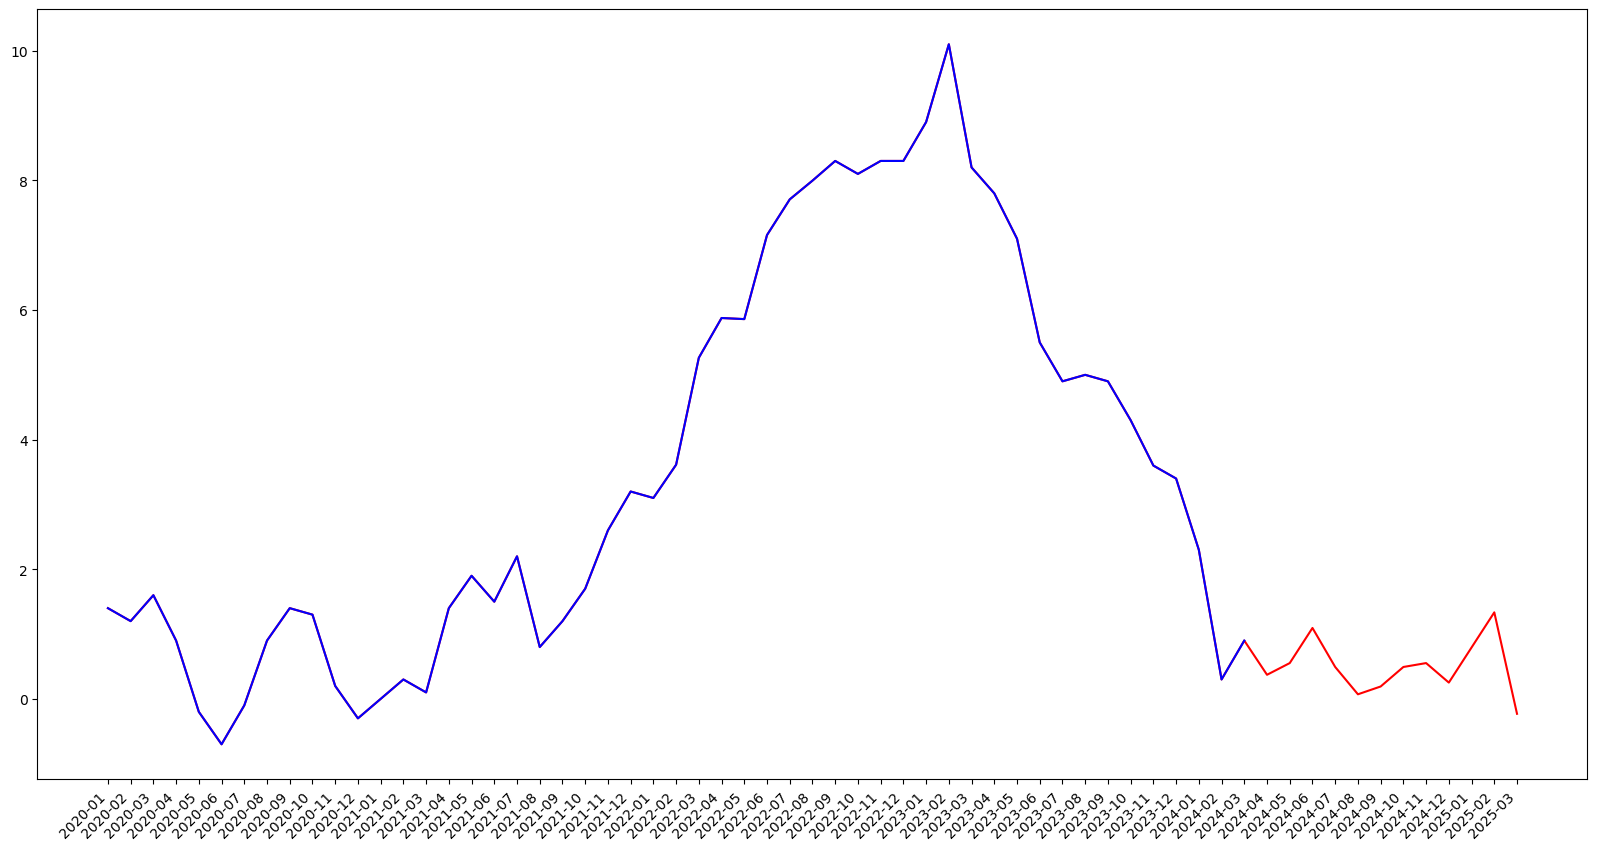

In [34]:
### Predictions from T+1 up to T+12
T = np.size(y)
nb_pred = 12 ##Choice of the forecast horizon
predictions = AR.predict(start=T,end=T+nb_pred-1) ##Prediction from index T to T+11

y_all = np.hstack([data['Inflation' ], predictions])

last_date = data['Mois'].iloc[-1] 
next_12_months = [last_date + pd.DateOffset(months=i) for i in range(1, 13)]
all_dates = pd.concat([data['Mois'], pd.Series(next_12_months)])

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(y_all, color='red')
plt.plot(data['Inflation'], color='blue')

ax.set_xticks(range(len(all_dates)))
ax.set_xticklabels([date.strftime('%Y-%m') for date in all_dates], rotation=45, ha='right')

plt.show() 